In [1]:
import tqdm
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing

In [2]:
 
def solve(L, a, b, metric):
    
    x = [cp.Variable() for _ in range(len(a))]

    if metric == "sw":
        objective = cp.Maximize(sum(-0.5*ai*xi**2 + bi*xi - L*xi for xi,ai,bi in zip(x, a, b)))
    elif metric == "pf":
        objective = cp.Maximize(sum(cp.log(-0.5*ai*xi**2 + bi*xi - L*xi) for xi,ai,bi in zip(x, a, b)))
    elif metric == "mm":
        objective = cp.Maximize(cp.minimum(*[-0.5*ai*xi**2 + bi*xi -L*xi for xi,ai,bi in zip(x, a, b)]))
        
    constraints = [-0.5*ai*xi + bi - L >= 0 for xi,ai,bi in zip(x, a, b)]
    constraints += [xi >= 0 for xi in x]
    constraints += [sum(x) == L]

    problem = cp.Problem(objective, constraints)
    problem.solve(solver="ECOS", abstol=1e-6)
    
    solution = [xi.value.item() for xi in x]
    utility = sum(-0.5*ai*xi**2 + bi*xi - L*xi for xi,ai,bi in zip(solution, a, b))
    
    return problem.value, solution, utility


def solve_wrapper(params):
    
    L = params["L"]
    seed = params["seed"]
    n_users = params["n_users"]
    
    np.random.seed(seed)
    a = 10*np.random.rand(n_users) + 2
    b = 10*np.random.rand(n_users) + 2
    
    try:
        sw_val, sw_sol, sw_utility = solve(L, a, b, "sw")
        pf_val, pf_sol, pf_utility = solve(L, a, b, "pf")
        mm_val, mm_sol, mm_utility = solve(L, a, b, "mm")
    except:
        sw_val, sw_sol, sw_utility = np.nan, np.full(n_users, np.nan), np.nan
        pf_val, pf_sol, pf_utility = np.nan, np.full(n_users, np.nan), np.nan
        mm_val, mm_sol, mm_utility = np.nan, np.full(n_users, np.nan), np.nan
        
    return dict(
        n_users=n_users, seed=seed,
        sw_val=sw_val, sw_sol=sw_sol, sw_utility=sw_utility,
        pf_val=pf_val, pf_sol=pf_sol, pf_utility=pf_utility,
        mm_val=mm_val, mm_sol=mm_sol, mm_utility=mm_utility,
    )

In [3]:
params_list = [
    dict(L=L, n_users=n_users, seed=seed)
    for L in [1] for n_users in 2**np.arange(1, 10) for seed in range(100)
]

len(params_list)

900

In [4]:
%%time

pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
results = pool.map(solve_wrapper, params_list)
pool.close()

CPU times: user 223 ms, sys: 403 ms, total: 626 ms
Wall time: 32.8 s


In [5]:
# calculate price of fairness (pof)
df = pd.DataFrame(results)
df["pf_pof"] = (df.sw_utility - df.pf_utility) / df.sw_utility
df["mm_pof"] = (df.sw_utility - df.mm_utility) / df.sw_utility
df["diff_pof"] = df["mm_pof"] - df["pf_pof"]
df.loc[df.diff_pof<0, "diff_pof"] = np.nan


# aggregate
df_mean = df.groupby("n_users")[["pf_pof", "mm_pof", "diff_pof"]].mean().reset_index()
df_05 = df.groupby("n_users")[["pf_pof", "mm_pof", "diff_pof"]].quantile(0.05).reset_index()
df_95 = df.groupby("n_users")[["pf_pof", "mm_pof", "diff_pof"]].quantile(0.95).reset_index()

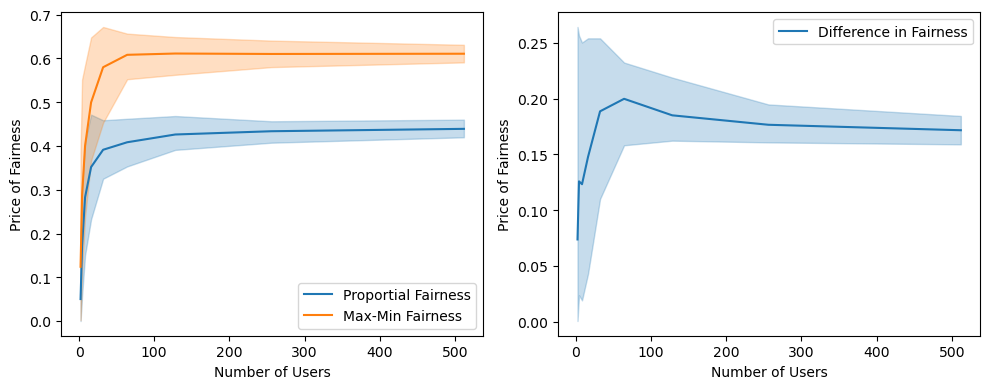

In [6]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(df_mean.n_users, df_mean.pf_pof, label="Proportial Fairness")
plt.plot(df_mean.n_users, df_mean.mm_pof, label="Max-Min Fairness")
plt.fill_between(df_mean.n_users, df_05.pf_pof, df_95.pf_pof, color="C0", alpha=0.25)
plt.fill_between(df_mean.n_users, df_05.mm_pof, df_95.mm_pof, color="C1", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_mean.n_users, df_mean.diff_pof, label="Difference in Fairness")
plt.fill_between(df_mean.n_users, df_05.diff_pof, df_95.diff_pof, color="C0", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend()

plt.tight_layout()
plt.show()

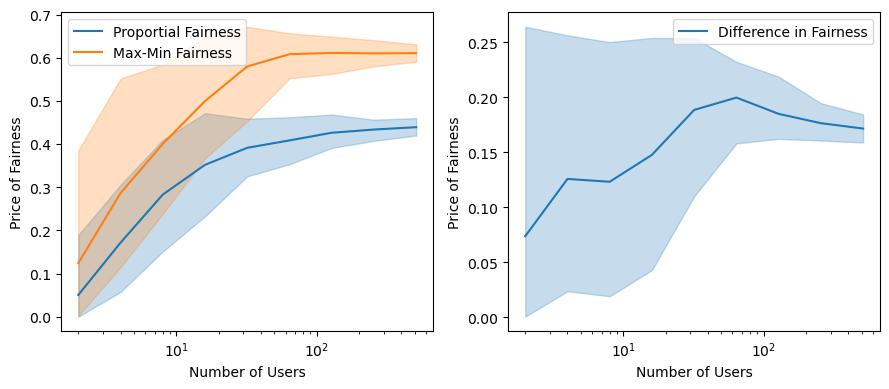

In [7]:
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.semilogx(df_mean.n_users, df_mean.pf_pof, label="Proportial Fairness")
plt.semilogx(df_mean.n_users, df_mean.mm_pof, label="Max-Min Fairness")
plt.fill_between(df_mean.n_users, df_05.pf_pof, df_95.pf_pof, color="C0", alpha=0.25)
plt.fill_between(df_mean.n_users, df_05.mm_pof, df_95.mm_pof, color="C1", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogx(df_mean.n_users, df_mean.diff_pof, label="Difference in Fairness")
plt.fill_between(df_mean.n_users, df_05.diff_pof, df_95.diff_pof, color="C0", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend()

plt.tight_layout()
plt.show()